In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
from matplotlib import pylab as plt

In [2]:
model = tf.keras.Sequential([
    hub.KerasLayer(
        name='inception_v1', trainable=False,
        handle='https://tfhub.dev/google/imagenet/inception_v1/classification/4'
    )
])
model.build([None, 224, 224, 3])

In [3]:
def load_imagenet_labels(file_path):
    labels_file = tf.keras.utils.get_file('ImageNetLabels.txt', file_path)
    with open(labels_file) as reader:
        f = reader.read()
        labels = f.splitlines()
    return np.array(labels)

In [4]:
imagenet_labels = load_imagenet_labels(
    'https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt'
)

In [5]:
def read_image(file_name):
    image = tf.io.read_file(file_name)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
#     image = tf.image.resize_with_pad(image, target_height=224, target_width=224)
    return image

In [6]:
img_url = {
    'Fireboat': 'http://storage.googleapis.com/download.tensorflow.org/example_images/San_Francisco_fireboat_showing_off.jpg',
    'Giant Panda': 'http://storage.googleapis.com/download.tensorflow.org/example_images/Giant_Panda_2.jpeg',
}

img_paths = {name: tf.keras.utils.get_file(name, url) for (name, url) in img_url.items()}
img_name_tensors = {name: read_image(img_path) for (name, img_path) in img_paths.items()}

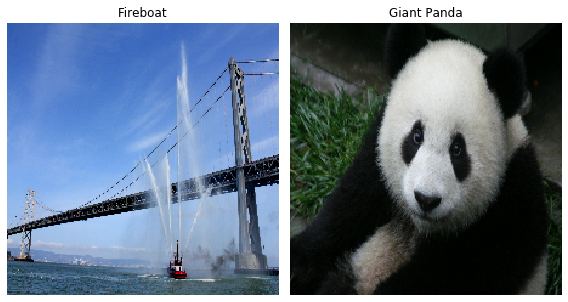

In [7]:
plt.figure(figsize=(8, 8))
for n, (name, img_tensors) in enumerate(img_name_tensors.items()):
    ax = plt.subplot(1, 2, n+1)
    ax.imshow(img_tensors)
    ax.set_title(name)
    ax.axis('off')
plt.tight_layout()

In [8]:
def top_k_predictions(img, k=3):
    image_batch = tf.expand_dims(img, 0)
    predictions = model(image_batch)
    probs = tf.nn.softmax(predictions, axis=-1)
    top_probs, top_idxs = tf.math.top_k(input=probs, k=k)
    top_labels = imagenet_labels[tuple(top_idxs)]
    return top_labels, top_probs[0]

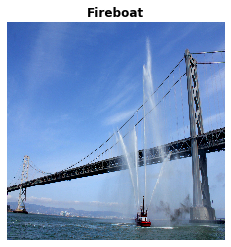

fireboat: 74.1%
pier: 3.1%
suspension bridge: 2.0%


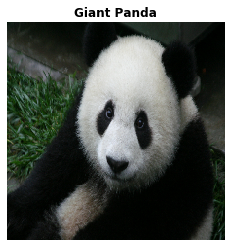

giant panda: 95.6%
colobus: 0.1%
indri: 0.1%


In [9]:
for (name, img_tensor) in img_name_tensors.items():
    plt.imshow(img_tensor)
    plt.title(name, fontweight='bold')
    plt.axis('off')
    plt.show()
    pred_label, pred_prob = top_k_predictions(img_tensor)
    for label, prob in zip(pred_label, pred_prob):
        print(f'{label}: {prob:0.1%}')

In [10]:
alphas = tf.linspace(start=0.0, stop=1.0, num=51)
baseline = tf.zeros(shape=(224, 224, 3))

In [11]:
def interpolate_images(baseline, image, alphas):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0)
    input_x = tf.expand_dims(image, axis=0)
    delta = input_x - baseline_x
    images = baseline_x +  alphas_x * delta
    return images

In [12]:
interpolated_images = interpolate_images(
    baseline=baseline,image=img_name_tensors['Fireboat'],alphas=alphas)

In [13]:
def compute_gradients(images, target_class_idx):
    with tf.GradientTape() as tape:
        tape.watch(images)
        logits = model(images)
        probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
    return tape.gradient(probs, images)

In [14]:
path_gradients = compute_gradients(
    images=interpolated_images,
    target_class_idx=tf.constant(555)
)

In [15]:
def integral_approximation(gradients):
    # riemann_trapezoidal
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis=0)
    return integrated_gradients

In [16]:
@tf.function
def integrated_gradients(baseline, image, target_class_idx, m_steps=300, batch_size=32):
    alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps)
    integrated_gradients = 0.0
    ds = tf.data.Dataset.from_tensor_slices(alphas).batch(batch_size)
    for batch in ds:
        batch_interpolated_inputs = interpolate_images(
            baseline=baseline, image=image, alphas=batch
        )
        batch_gradients = compute_gradients(
            images=batch_interpolated_inputs,
            target_class_idx=target_class_idx
        )
        integrated_gradients += integral_approximation(gradients=batch_gradients)
    scaled_integrated_gradients = (image - baseline) * integrated_gradients
    return scaled_integrated_gradients

In [17]:
ig_attributions = integrated_gradients(
    baseline=baseline,
    image=img_name_tensors['Fireboat'],
    target_class_idx=555
)

In [18]:
def plot_img_attributions(
    baseline, image, target_class_idx,
    m_steps=tf.constant(50), cmap=None, overlay_alpha=0.4):
    
    attributions = integrated_gradients(
        baseline=baseline, image=image,
        target_class_idx=target_class_idx, m_steps=m_steps
    )
    attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

    fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

    axs[0, 0].set_title('Baseline image')
    axs[0, 0].imshow(baseline)
    axs[0, 0].axis('off')

    axs[0, 1].set_title('Original image')
    axs[0, 1].imshow(image)
    axs[0, 1].axis('off')

    axs[1, 0].set_title('Attribution mask')
    axs[1, 0].imshow(attribution_mask, cmap=cmap)
    axs[1, 0].axis('off')

    axs[1, 1].set_title('Overlay')
    axs[1, 1].imshow(attribution_mask, cmap=cmap)
    axs[1, 1].imshow(image, alpha=overlay_alpha)
    axs[1, 1].axis('off')

    plt.tight_layout()
    return fig

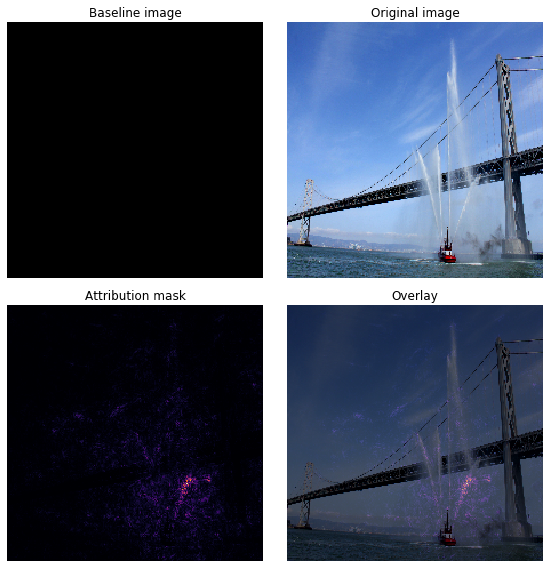

In [19]:
_ = plot_img_attributions(
    image=img_name_tensors['Fireboat'],
    baseline=baseline, target_class_idx=555,
    m_steps=2400, cmap=plt.cm.inferno, overlay_alpha=0.4
)

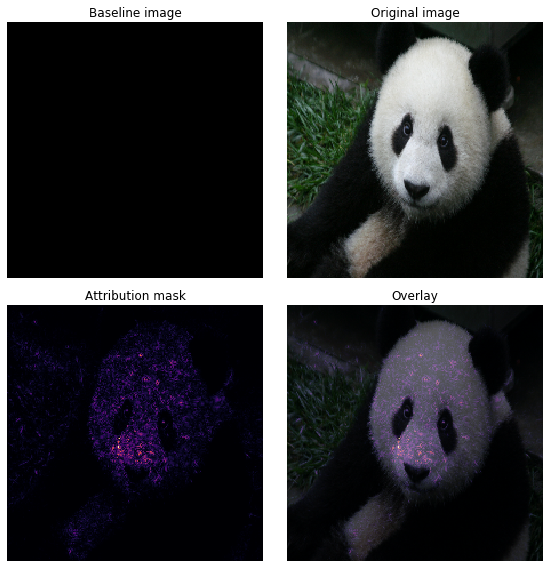

In [20]:
_ = plot_img_attributions(
    image=img_name_tensors['Giant Panda'],
    baseline=baseline, target_class_idx=389,
    m_steps=1100, cmap=plt.cm.inferno, overlay_alpha=0.4
)